In [5]:
import torch
import numpy as np
import argparse
import pickle
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm

from data_grn_processing import load_grn_dataset_dgl
from model_grn import GRNGNN, prediction_dgl
from utils import set_config_args, get_comp_g_edge_labels, get_comp_g_path_labels
from utils import src_tgt_khop_in_subgraph, eval_edge_mask_auc, eval_edge_mask_topk_path_hit


# DGL 그래프에서 feature dimension 가져오기 (feat이 아닌 모든 ndata 속성 사용)
def get_in_dim(mp_g):
    """
    DGL 그래프에서 모든 노드 feature의 총 차원을 계산하는 함수
    """
    node_feats = []
    for key in mp_g.ndata.keys():  # 모든 노드 feature 속성 확인
        feat = mp_g.ndata[key]  # 해당 feature 텐서 가져오기
        if len(feat.shape) == 2:  # (num_nodes, feature_dim) 형태일 경우만 추가
            node_feats.append(feat.shape[1])
    
    if not node_feats:
        raise ValueError("No valid node features found in graph! Check ndata.")

    return sum(node_feats)  # 모든 feature 차원을 더해서 총 in_dim 반환


parser = argparse.ArgumentParser(description='Explain link predictor')
parser.add_argument('--device_id', type=int, default=0)

'''
Dataset args
'''
parser.add_argument('--dataset_dir', type=str, default='datasets')
parser.add_argument('--dataset_name', type=str, default='Ecoli1_basic_graph')
parser.add_argument('--valid_ratio', type=float, default=0.1) 
parser.add_argument('--test_ratio', type=float, default=0.2)
parser.add_argument('--max_num_samples', type=int, default=-1, 
                    help='maximum number of samples to explain, for fast testing. Use all if -1')

'''
GNN args
'''
parser.add_argument('--hidden_dim_1', type=int, default=128)
parser.add_argument('--hidden_dim_2', type=int, default=64)
parser.add_argument('--out_dim', type=int, default=32)
parser.add_argument('--saved_model_dir', type=str, default='saved_models')
parser.add_argument('--saved_model_name', type=str, default='basic_data_Ecoli1_InSilicoSize100_model')

'''
Explanation args
'''
parser.add_argument('--num_hops', type=int, default=2, help='computation graph number of hops') 
parser.add_argument('--saved_explanation_dir', type=str, default='saved_explanations',
                    help='directory of saved explanations')
parser.add_argument('--eval_explainer_names', nargs='+', default=['pagelink'],
                    help='name of explainers to evaluate') 
parser.add_argument('--eval_path_hit', default=False, action='store_true', 
                    help='Whether to save the explanation') 
parser.add_argument('--config_path', type=str, default='', help='path of saved configuration args')

'''
'''

parser.add_argument('--dec', type=str, default='dot_sum', choices=['dot', 'cos', 'ele', 'cat', 'dot_sum'],
                   help='Edge predictor에서 사용할 디코딩 연산 방식')
parser.add_argument('--af_val', type=str, default='F.silu', choices=['F.silu', 'F.sigmoid', 'F.tanh'],
                   help='Edge predictor에서 사용할 활성화 함수')
parser.add_argument('--var', type=str, default='ChebConv', choices=['ChebConv', 'SSGConv', 'ClusterGCNConv', 'HypergraphConv'],
                   help='GNN 변형 방식 선택')
parser.add_argument('--num_layers', type=int, default=4,
                   help='GNN의 레이어 개수')
parser.add_argument('--aggr', type=str, default='sum', choices=['sum', 'add'],
                   help='operation passed to dgl.EdgePredictor')
parser.add_argument('--num_epochs', type=int, default=20, help='How many epochs to learn the mask')


args = parser.parse_args('')

if args.config_path:
    args = set_config_args(args, args.config_path, args.dataset_name, 'train_eval')  


if torch.cuda.is_available() and args.device_id >= 0:
    device = torch.device('cuda', index=args.device_id)
else:
    device = torch.device('cpu')


g, processed_g = load_grn_dataset_dgl(args.dataset_dir,
                                                                                  args.dataset_name,
                                                                                  args.valid_ratio,
                                                                                  args.test_ratio)
mp_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = [g for g in processed_g]


try:
    in_dim = get_in_dim(mp_g)
except KeyError:
    raise ValueError("Graph does not contain 'feat' in node features. Ensure features are properly assigned.")


model = GRNGNN(in_dim, args.hidden_dim_1, args.hidden_dim_2, args.out_dim,args.dec,args.af_val,args.num_layers,args.num_epochs,args.aggr,args.var).to(device)#Net(data.num_features, data.num_features, 128, 64).to(device) #self, in_channels, hidden1_channels, hidden2_channels,out_channels


if not args.saved_model_name:
    args.saved_model_name = f'{args.dataset_name}_model'

state = torch.load(f'{args.saved_model_dir}/{args.saved_model_name}.pth', map_location='cuda')
model.load_state_dict(state)    

test_src_nids, test_tgt_nids = test_pos_g.edges()
comp_graphs = defaultdict(list)
comp_g_labels = defaultdict(list)


## Pick one example graph

In [16]:
i = 4
# Get the k-hop subgraph
src_nid, tgt_nid = test_src_nids[i], test_tgt_nids[i]
comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids = src_tgt_khop_in_subgraph( src_nid,
                                                                                     tgt_nid,
                                                                                            mp_g,
                                                                                            args.num_hops)

print(f"src_nid : {src_nid}")
print(f"tgt_nid: {tgt_nid}")

print(f"comp_g : {comp_g}")

with torch.no_grad():
    pred = prediction_dgl(model, comp_g, args.af_val, args.dec)

print(f"pred : {pred}")

# Extract edges from the graph
edge_index = torch.stack(comp_g.edges(), dim=0).cpu().numpy()
src_tgt_pair = np.array([comp_g_src_nid.cpu().numpy(), comp_g_tgt_nid.cpu().numpy()]).reshape(2, 1)
print(f"edge_index : {edge_index}")
print(f"src_tgt_pair : {src_tgt_pair}")
# Check if the prediction contains this specific edge
mask = np.all(edge_index == src_tgt_pair, axis=0)
print(f"mask : {mask}")
print(f"pred[mask] : {pred[mask][0]}")
print(f"mask.sum : {mask.sum()}")
if mask.sum() > 0 and pred[mask][0]:  # src_nid -> tgt_nid에 대한 예측 값이 1인지 확인
    src_tgt = (int(src_nid), int(tgt_nid))
    comp_graphs[src_tgt] = [comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids]

    print(f"comp_grpahs : {comp_graphs}")


src_nid : 45
tgt_nid: 46
comp_g : Graph(num_nodes=5, num_edges=7,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
pred : [1 0 1 0 0 0 1]
edge_index : [[0 1 2 2 3 3 3]
 [2 2 0 4 0 2 4]]
src_tgt_pair : [[3]
 [4]]
mask : [False False False False False False  True]
pred[mask] : 1
mask.sum : 1
comp_grpahs : defaultdict(<class 'list'>, {(45, 46): [tensor(3), tensor(4), Graph(num_nodes=5, num_edges=7,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}),

## Load saved explanation

In [17]:
explainer = args.eval_explainer_names[0]
print(f"explainer : {explainer}")
saved_explanation_mask = f'{explainer}_{args.saved_model_name}_pred_edge_to_comp_g_edge_mask'
print(f"saved_explanation_mask : {saved_explanation_mask}")
saved_file = Path.cwd().joinpath(args.saved_explanation_dir, saved_explanation_mask)
with open(saved_file, "rb") as f:
    explanation_mask = pickle.load(f)

print(f"explanation_mask : {explanation_mask}")

explainer : pagelink
saved_explanation_mask : pagelink_basic_data_Ecoli1_InSilicoSize100_model_pred_edge_to_comp_g_edge_mask
explanation_mask : {(43, 9): tensor([-0.3943, -0.1814, -1.1273,  0.0619, -0.0515, -0.2472, -0.2656,    -inf,
        -0.1400, -0.4582,    -inf, -0.1548, -0.7125,  0.9660,  0.1329, -0.0785,
         0.5486,  0.5040]), (62, 59): tensor([ 1.1378, -0.3204, -0.2206,  0.0567,  0.0453, -0.1805,  0.4035,    -inf,
         0.3622, -0.3079,  0.0614,    -inf,  0.4641,  0.0414, -0.1678, -0.0406,
         0.9230, -0.8123]), (97, 98): tensor([-0.3452]), (37, 8): tensor([-0.4438,  0.9096, -0.4030,    -inf,    -inf,    -inf]), (45, 21): tensor([-0.9756,  0.1708]), (4, 8): tensor([-0.3105,    -inf,  0.2890,    -inf,    -inf,    -inf]), (84, 3): tensor([ 0.5916, -0.5675,  0.2584,  0.1694]), (65, 64): tensor([ 0.5787, -0.1249]), (92, 94): tensor([ 0.3725,  0.5669, -0.1351,  0.5079,  0.4169]), (43, 62): tensor([-0.0275, -0.1120,  0.3529, -0.4097,  0.4531,  1.0310,    -inf,  0.0907,


## Extract paths and construct the explanation graph to plot

In [22]:
import dgl
def get_exp_g(g, paths, src_nid, tgt_nid):
    path_eids = []
    for path in paths:
        print(f"path : {path}")
        for edge in path:
            print(f"edge : {edge}")
            u, v = edge
            eids = comp_g.edge_ids(u, v)
            # ✅ eids가 텐서인 경우 리스트로 변환
            if isinstance(eids, torch.Tensor):
                eids = eids.tolist()
            elif not isinstance(eids, list):
                eids = [eids]  # 단일 값이면 리스트로 변환
            
            path_eids.extend(eids)  # ✅ 리스트에 추가
            
    # ✅ path_eids가 비어 있지 않다면 텐서로 변환
    path_eids = torch.tensor(path_eids, dtype=torch.long) if path_eids else torch.tensor([], dtype=torch.long)

    print(f"Converted path_eids: {path_eids}")  # 디버깅 출력

    exp_g = g

    remove_eids = g.edges(form='eid')
    if path_eids.numel() > 0:  # ✅ 빈 텐서일 경우 예외 처리
        mask = torch.ones(remove_eids.shape, dtype=torch.bool)
        mask[path_eids] = False  # ✅ path_eids에 해당하는 엣지만 유지
        remove_eids = remove_eids[mask]  # ✅ 제거할 엣지만 남기기

    exp_g = dgl.remove_edges(exp_g, remove_eids) # creates a new graph
    exp_g = dgl.compact_graphs(exp_g)

    # Get src and tgt nid in the explanation graph
    # Note: the input graph should have node data dgl.NID
    exp_g_src_nid_in_g = exp_g.ndata[dgl.NID]
    exp_g_src_nid = (exp_g_src_nid_in_g == src_nid).nonzero().view(-1)
    exp_g_tgt_nid = (exp_g_src_nid_in_g == tgt_nid).nonzero().view(-1)

    return exp_g, exp_g_src_nid, exp_g_tgt_nid   

comp_g_edge_mask_dict = explanation_mask[src_tgt]
print(f"comp_g_edge_mask_dict : {comp_g_edge_mask_dict}")
from explainer_grn import PaGELink
pagelink = PaGELink(model)
paths = pagelink.get_paths(comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_edge_mask_dict)

print(f"paths : {paths}")


exp_g, exp_g_src_nid, exp_g_tgt_nid = get_exp_g(comp_g, 
                                                paths,
                                                comp_g_src_nid,
                                                comp_g_tgt_nid)

comp_g_edge_mask_dict : tensor([-0.0975,  0.4874, -0.2163,  0.0384,  0.7170, -0.5909, -0.2515])
edge_mask shape: torch.Size([7])
ghomo num_edges: 7
paths : [[[3, 4]]]
path : [[3, 4]]
edge : [3, 4]
Converted path_eids: tensor([6])


## Set plot arguments and plot

In [19]:
from utils import plot_homo_graph

edge_kwargs = {"edge_color" : '#00B050',
               "style" : '-',
               "width" : 4,
               "arrows" : True,
               "arrowstyle" : '-|>',
               "arrowsize" : 30}

selected_edge_kwargs = {"edge_color" : 'red',
                        "style" : '--',
                        "width" : 3,
                        "arrows" : False}
selected_edges = list(zip(exp_g_src_nid.tolist(), exp_g_tgt_nid.tolist()))


dict_keys(['wildtype', 'id', '_ID'])


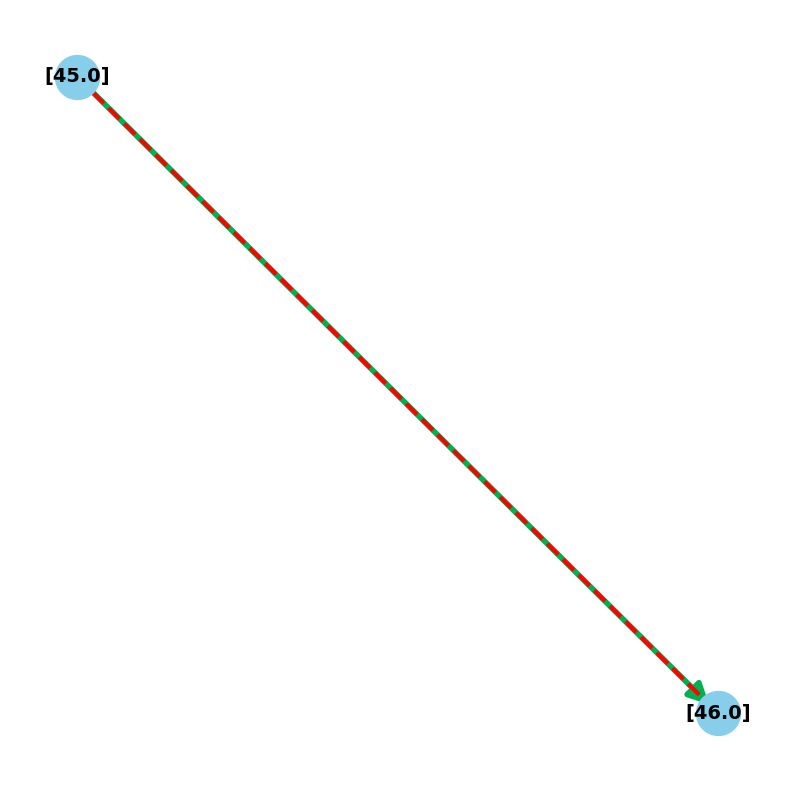

In [20]:
print(exp_g.ndata.keys())  # exp_g의 노드 속성 확인

nx_graph = plot_homo_graph(exp_g,
                             label='id',
                             edge_kwargs=edge_kwargs,
                             selected_edge_kwargs=selected_edge_kwargs,
                             selected_edge=selected_edges)